In [13]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import glob
import os

from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
import itertools
import matplotlib
import calpgs
from admix.data import pval2chisq, zsc2pval
from utils import load_r2_result, plot_heatmap, plot_heatmap2

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [16]:
group = "white_british"
# group = "other"

PREFIX = ""

In [21]:
df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
    result_dir=f"out/{PREFIX}/", group=group
)

plot_trait_list = df_display["id"].values

df_diff_plot = df_diff.loc[covar_map.keys(), plot_trait_list]
# df_pval_plot = df_diff_pval[plot_trait_list]
df_pval_plot = df_diff_zscore.loc[covar_map.keys(), plot_trait_list].applymap(zsc2pval)
df_annot = pd.DataFrame("", index=df_diff_plot.index, columns=df_pval_plot.columns)
for r in df_diff_plot.index:
    for c in df_diff_plot.columns:
        diff, pval = df_diff_plot.loc[r, c], df_pval_plot.loc[r, c]
        if pval < 0.05 / df_diff_plot.size:
            annot = f"{diff * 100:+.0f}%"
        elif pval < 0.05 / df_diff_plot.shape[0]:
            annot = "*"
        else:
            annot = ""
        df_annot.loc[r, c] = annot

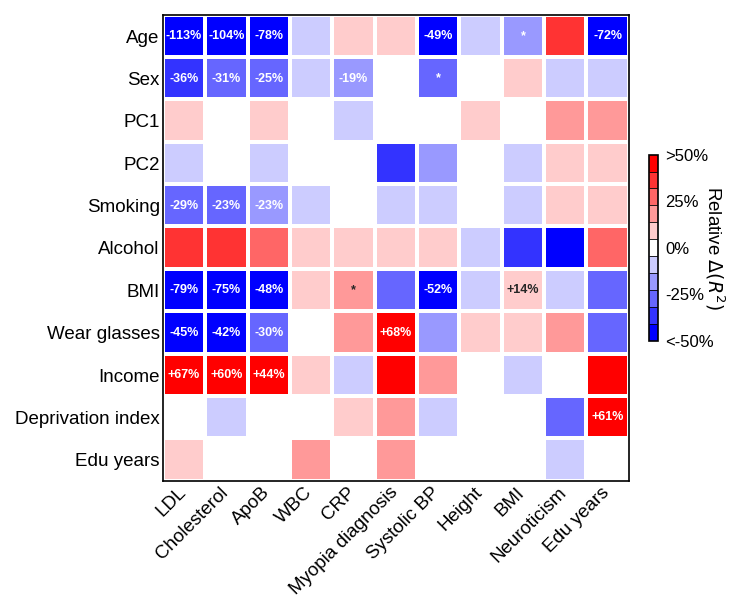

In [22]:
fig, ax = plot_heatmap(
    df_diff_plot,
    df_annot,
    annot_kws={"fontsize": 6, "weight": "bold"},
    cmap=plt.get_cmap("bwr", 11),
    squaresize=45,
    heatmap_vmin=-0.5,
    heatmap_vmax=0.5,
    heatmap_linecolor="white",
    heatmap_linewidths=1.0,
    heatmap_cbar_kws=dict(
        use_gridspec=False,
        location="right",
        fraction=0.0188,
        pad=0.04,
        drawedges=True,
    ),
)
ax.set_xlabel(None)
ax.set_xticklabels([trait_map[x.get_text()] for x in ax.get_xticklabels()], fontsize=9)

ax.set_ylabel(None)
ax.set_yticklabels([covar_map[y.get_text()] for y in ax.get_yticklabels()], fontsize=9)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])
cbar.set_ticklabels(["<-50%", "-25%", "0%", "25%", ">50%"])
cbar.ax.set_ylabel("Relative $\Delta (R^2)$", rotation=270, fontsize=9, labelpad=6.0)
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(0.8)

cbar.ax.tick_params(labelsize=8)
cbar.ax.tick_params(size=0)

for _, spine in ax.spines.items():
    spine.set_visible(True)

fig.savefig(f"results/heatmap.{group}.pdf", bbox_inches="tight")
fig.show()

In [9]:
assert False

AssertionError: 

# Other ways to plot the data

In [ ]:
import seaborn as sns

In [ ]:
df_val = df_diff_plot.copy()
df_size = df_diff_zscore.applymap(lambda x: np.clip(np.abs(x) / 4, 0, 1))
df_size = df_size.loc[df_val.index, df_val.columns]
df_val = df_val.rename(index=covar_map, columns=trait_map)
df_size = df_size.rename(index=covar_map, columns=trait_map)

In [ ]:
fig, ax = plot_heatmap2(
    df_val,
    df_size,
    squaresize=60,
    cmap=plt.get_cmap("bwr", 11),
)